# False clouds in ABI static features

Clouds that do not move or evolve are more likely to be false clouds. This program overlays ABI imagery in order to see which features do not evolve with time. 

ABI data is from /mnt/grb/goes16/ on smiller2

In [1]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from sklearn.preprocessing import normalize
import fnmatch

In [2]:
date = "20220914"

root = "/home/jturner/false_low_clouds_2023/Static_Features/"+date

## Visualizing a specific time

In [3]:
data_07 = xr.open_dataset(root+'/OR_ABI-L1b-RadF-M6C07_G16_s20222570500207_e20222570509526_c20222570509568.nc')

data_14 = xr.open_dataset(root+'/OR_ABI-L1b-RadF-M6C14_G16_s20222570500207_e20222570509515_c20222570509597.nc')

In [4]:
#--- Filter to the region

#---Georges Bank
min_lon = -71.5
min_lat = 37
max_lon = -64
max_lat = 42.5

In [5]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    # Added absolute to remove error
    r_s = (-b - np.sqrt(np.absolute(b**2 - 4*a*c)))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"
    return ds

In [6]:
def get_xy_from_latlon(ds, lats, lons):
    lat1, lat2 = lats
    lon1, lon2 = lons

    lat = ds.lat.data
    lon = ds.lon.data
    
    x = ds.x.data
    y = ds.y.data
    
    x,y = np.meshgrid(x,y)
    
    x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]
    y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)] 
    
    return ((min(x), max(x)), (min(y), max(y)))

In [7]:
ds_07 = calc_latlon(data_07)
ds_14 = calc_latlon(data_14)

In [8]:
lats = (min_lat, max_lat)
lons = (min_lon, max_lon)

In [9]:
((x1,x2), (y1, y2)) = get_xy_from_latlon(ds_07, lats, lons)

In [10]:
subset_07 = ds_07.sel(x=slice(x1, x2), y=slice(y2, y1))
subset_14 = ds_14.sel(x=slice(x1, x2), y=slice(y2, y1))

Calculating the brightness temperature from the radiance: 
* from the GOES-R documentation (https://www.star.nesdis.noaa.gov/goesr/docs/ATBD/Imagery.pdf)

$$
T = [fk2 / (\text{alog}((fk1/L_\lambda) + 1)) - bc1]/bc2
$$
* $\text{alog}$ is the natural log
* $L_\lambda$ is the radiance
* the other variables are in the ABI data

In [11]:
T_07 = (subset_07.planck_fk2/(np.log((subset_07.planck_fk1/subset_07.Rad)+1)) - subset_07.planck_bc1)/subset_07.planck_bc2
T_14 = (subset_14.planck_fk2/(np.log((subset_14.planck_fk1/subset_14.Rad)+1)) - subset_14.planck_bc1)/subset_14.planck_bc2

BTD = T_14 - T_07

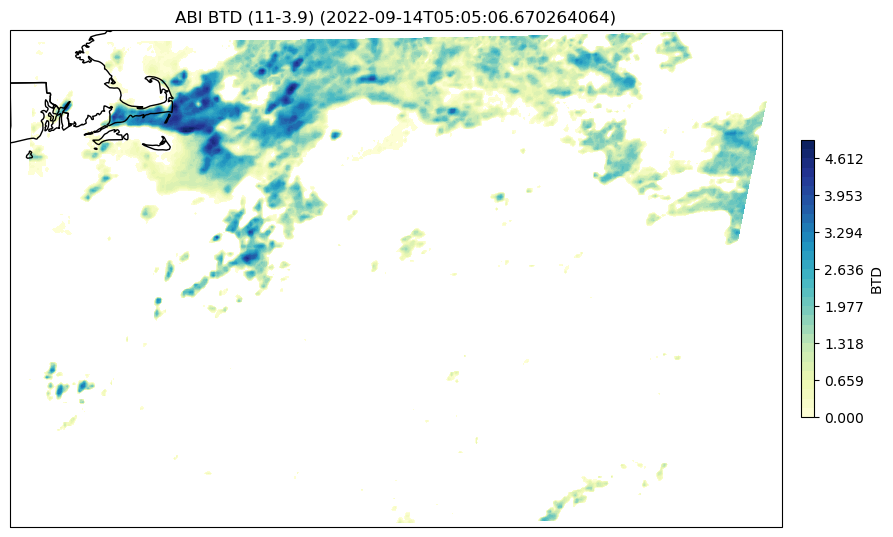

In [12]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.YlGnBu
levels = np.linspace(0, np.amax(BTD), 31)

c=ax.contourf(subset_07.Rad.lon, subset_07.Rad.lat, BTD, cmap=cmap, levels=levels)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('ABI BTD (11-3.9) ('+str(subset_07.t.values)+')')
clb.set_label('BTD')

ax.add_feature(cfeature.STATES)

## Combining the range of times

In [13]:
#--- Initialize the 2D summed array with zeroes

BTD_prod = [ [1]*len(BTD[0]) for i in range(len(BTD))]

#--- For each of the files in dir, crop and calculate BTD

for filename in os.listdir(root):
    
    #--- To avoid duplicates, loop through only Band 07 data
    if filename[0:21] == 'OR_ABI-L1b-RadF-M6C07':
        
        print(filename)
            
        data_07 = xr.open_dataset(root+'/'+filename)
        
        print('Processing 07 band for '+filename[27:31]+'-'+filename[31:34]+' '+filename[34:36]+':'+filename[36:38])

        ds_07 = calc_latlon(data_07)

        ((x1,x2), (y1, y2)) = get_xy_from_latlon(ds_07, lats, lons)

        subset_07 = ds_07.sel(x=slice(x1, x2), y=slice(y2, y1))
        
        #--- Search for corresponding Band 14 file:
        files = os.listdir(root) 
        pattern = 'OR_ABI-L1b-RadF-M6C14*'+filename[27:38]+'*.nc'
        filename_14 = str(fnmatch.filter(files, pattern)[0])
        
        print(filename_14)
    
        data_14 = xr.open_dataset(root+'/'+filename_14)
        
        print('Processing 14 band for '+filename_14[27:31]+'-'+filename_14[31:34]+' '+filename_14[34:36]+':'+filename_14[36:38])

        ds_14 = calc_latlon(data_14)

        ((x1,x2), (y1, y2)) = get_xy_from_latlon(ds_14, lats, lons)

        subset_14 = ds_14.sel(x=slice(x1, x2), y=slice(y2, y1))
        
        #--- Calculate BTD and take product of the data over time
        T_07 = (subset_07.planck_fk2/(np.log((subset_07.planck_fk1/subset_07.Rad)+1)) - subset_07.planck_bc1)/subset_07.planck_bc2
        T_14 = (subset_14.planck_fk2/(np.log((subset_14.planck_fk1/subset_14.Rad)+1)) - subset_14.planck_bc1)/subset_14.planck_bc2

        BTD = T_14 - T_07
        
        
        #--- set negative values to zero
        BTD_lim = np.where(BTD < 0, 0, BTD)
        
        #--- take product of new time step against previous
        BTD_prod = BTD_prod*BTD_lim
        
        #--- limit to between zero and 3
        #--- this slightly dulls the sharp edges of the FLC signal
        BTD_prod = np.where(BTD_prod > 3, 3, BTD_prod)

OR_ABI-L1b-RadF-M6C07_G16_s20222570750207_e20222570759526_c20222570759567.nc
Processing 07 band for 2022-257 07:50
OR_ABI-L1b-RadF-M6C14_G16_s20222570750207_e20222570759515_c20222570759591.nc
Processing 14 band for 2022-257 07:50
OR_ABI-L1b-RadF-M6C07_G16_s20222570530207_e20222570539526_c20222570539568.nc
Processing 07 band for 2022-257 05:30
OR_ABI-L1b-RadF-M6C14_G16_s20222570530207_e20222570539515_c20222570539590.nc
Processing 14 band for 2022-257 05:30
OR_ABI-L1b-RadF-M6C07_G16_s20222570600207_e20222570609526_c20222570609575.nc
Processing 07 band for 2022-257 06:00
OR_ABI-L1b-RadF-M6C14_G16_s20222570600207_e20222570609515_c20222570609587.nc
Processing 14 band for 2022-257 06:00
OR_ABI-L1b-RadF-M6C07_G16_s20222570700207_e20222570709526_c20222570709568.nc
Processing 07 band for 2022-257 07:00
OR_ABI-L1b-RadF-M6C14_G16_s20222570700207_e20222570709515_c20222570709594.nc
Processing 14 band for 2022-257 07:00
OR_ABI-L1b-RadF-M6C07_G16_s20222570510207_e20222570519526_c20222570519570.nc
Pro

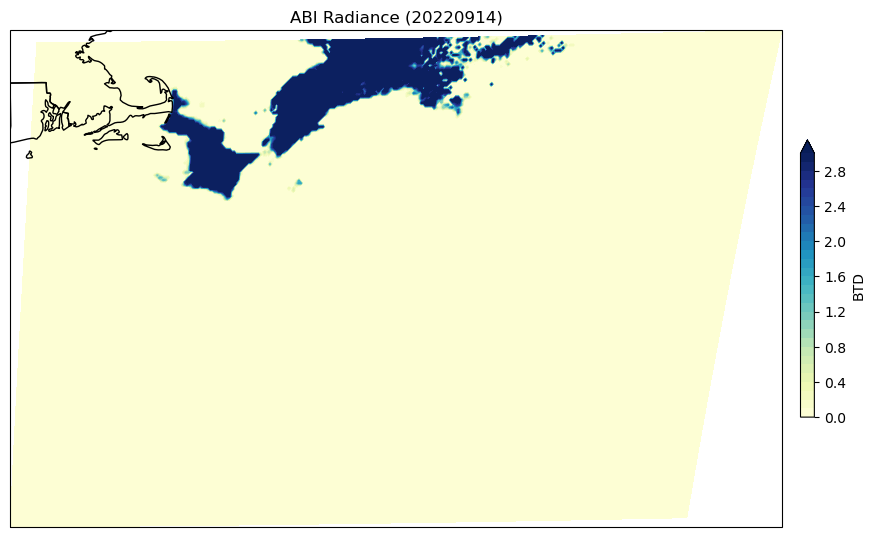

In [14]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.YlGnBu
#levels = np.linspace(np.amin(BTD), np.amax(BTD), 31)
levels = np.linspace(0, 3, 31)

c=ax.contourf(subset_07.Rad.lon, subset_07.Rad.lat, BTD_prod, cmap=cmap, levels=levels, extend='max')
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('ABI Radiance ('+date+')')
clb.set_label('BTD')

ax.add_feature(cfeature.STATES)